# License Plate Detection Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/license-plate-recognition/blob/main/README.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/license-plate-recognition/blob/main/README.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="
    https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/README.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>
<br>
<br>

### Install Application Dependecies 

In [15]:
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/requirements.txt
!pip -q install -r requirements.txt


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [16]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File '00-start-eva-server.ipynb' already there; not retrieving.

nohup eva_server > eva.log 2>&1 &

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Load the Video for analysis

In [17]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/1.mp4"
cursor.execute('DROP TABLE IF EXISTS MyVideos;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD VIDEO "1.mp4" INTO MyVideos;')
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                       0
0  Table Successfully dropped: MyVideos
@query_time: 0.044861739967018366
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded VIDEO: 1
@query_time: 0.317170986905694


### Create Custom UDF for Car Plate Detection

In [18]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/car_plate_detector.py"
!wget -nc "https://www.dropbox.com/s/dl268g907vy7hxy/car_plate_detection_segmentation_model.pth"
!mv car_plate_detection_segmentation_model.pth model.pth
cursor.execute("DROP UDF IF EXISTS CarPlateDetector;")
response = cursor.fetch_all()
print(response)
cursor.execute("""CREATE UDF IF NOT EXISTS CarPlateDetector
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (results NDARRAY FLOAT32(ANYDIM, ANYDIM))
      TYPE  Classification
      IMPL  'car_plate_detector.py';
      """) 
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
 Empty DataFrame
Columns: []
Index: []
@query_time: 0.00748234405182302
@status: ResponseStatus.SUCCESS
@batch: 
                                                           0
0  UDF CarPlateDetector successfully added to the database.
@query_time: 3.9512349141296


### Run Car Plate Detector on Video

In [19]:
cursor.execute("""SELECT id, CarPlateDetector(data)
                  FROM MyVideos WHERE id < 1""")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
    myvideos.id  \
0            0   

                                                                              carplatedetector.results  
0  [[0 0 0 ... 0 0 0], [0 0 0 ... 0 0 0], [0 0 0 ... 0 0 0], [0 0 0 ... 0 0 0], [0 0 0 ... 0 0 0], ...  
@query_time: 6.908392279874533


### Visualize Model Output on Video

In [20]:
from pprint import pprint
from matplotlib import pyplot as plt
import cv2
import numpy as np

def annotate_video(detections, input_video_path):

    print(detections)

    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))


    # Only looking at the first frame for now
    frame_id = 0
    ret, frame = vcap.read()
    plates_in_all_frames = []

    while ret:
        df = detections
        df = df[['carplatedetector.results']][df.index == frame_id]

        if df.size:
            dfList = df.values.tolist()
            mask = np.array(dfList[0][0])
            mask = mask.astype(np.uint8)

            contours, hierarchy = cv2.findContours(
                mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            plt.imshow(frame)
            plt.show()

            plates_within_this_frame = []
            for j, c in enumerate(contours):
                x,y,w,h = cv2.boundingRect(c)
                plate = frame[y:y+h, x:x+w]
                plates_within_this_frame.append(plate)

                image_file_name = "frame" + str(frame_id)+ "_plate" + str(j) + ".png"

                cv2.imwrite(image_file_name, plate)

                cv2.drawContours(frame, [c], 0,color2, 5)

                plt.imshow(plate)
                plt.show()

            plt.imshow(frame)
            plt.show()

            plates_in_all_frames.append(plates_within_this_frame)
            
        frame_id+=1

        ret, frame = vcap.read()

    return plates_in_all_frames


   myvideos.id                           carplatedetector.results
0            0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...


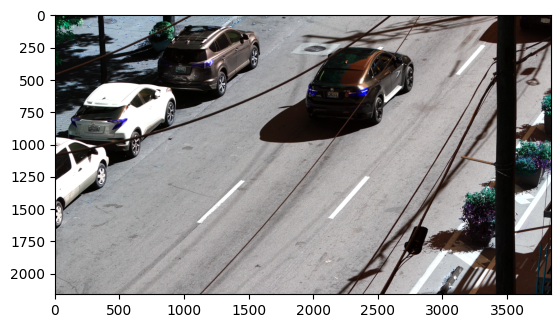

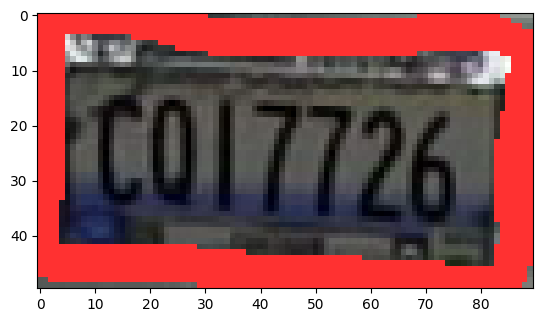

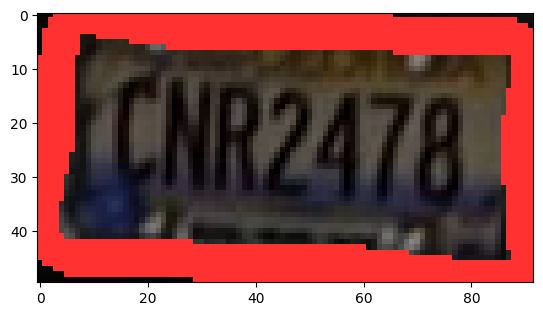

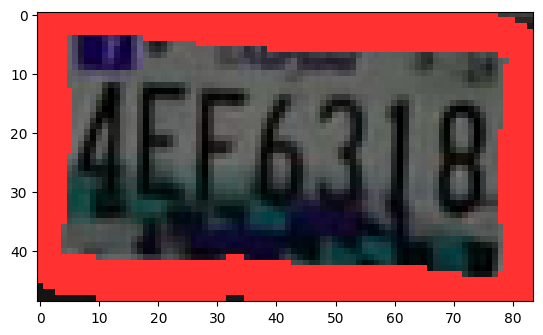

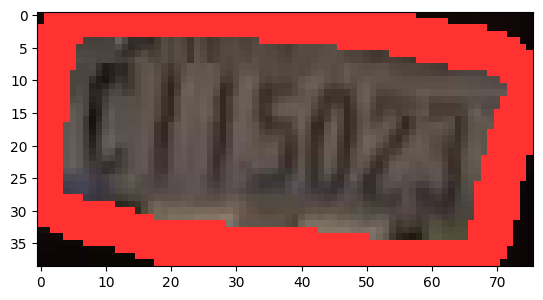

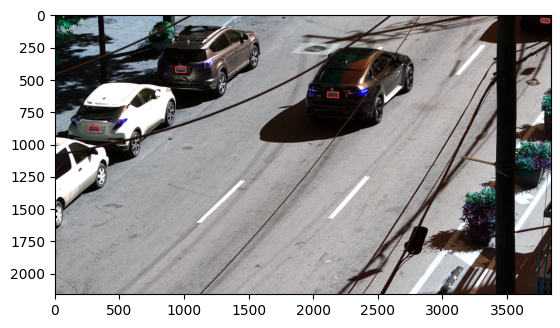

In [21]:
from ipywidgets import Video, Image
input_path = "1.mp4"
dataframe = response.batch.frames
car_plates = annotate_video(dataframe, input_path)

In [22]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/ocr_extractor.py"
cursor.execute("DROP UDF OCRExtractor;")
response = cursor.fetch_all()
print(response)
cursor.execute("""CREATE UDF IF NOT EXISTS OCRExtractor
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (labels NDARRAY STR(ANYDIM), bboxes NDARRAY FLOAT32(ANYDIM, 4),
              scores NDARRAY FLOAT32(ANYDIM))
      TYPE  Classification
      IMPL  'ocr_extractor.py';
      """)
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                        0
0  UDF OCRExtractor successfully dropped
@query_time: 0.019633171148598194
@status: ResponseStatus.SUCCESS
@batch: 
                                                       0
0  UDF OCRExtractor successfully added to the database.
@query_time: 2.8904840040486306


In [78]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/test_image_1.png"
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/test_image_2.png"
#for i, plates in enumerate(car_plates):
#    for j, plate in enumerate(plates):
i=0
j=0
file_name = "frame" + str(i)+ "_plate" + str(j) + ".png"
print(file_name)
cursor.execute('DROP TABLE IF EXISTS MyImages')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "' + file_name + '" INTO MyImages;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "test_image_1.png" INTO MyImages;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "test_image_2.png" INTO MyImages;')
response = cursor.fetch_all()
print(response)
cursor.execute("""SELECT OCRExtractor(data)
                FROM MyImages""")
response = cursor.fetch_all()
print(response)

frame0_plate0.png
@status: ResponseStatus.SUCCESS
@batch: 
                                       0
0  Table Successfully dropped: MyImages
@query_time: 0.029845752986148
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded IMAGE: 1
@query_time: 0.05161382909864187
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded IMAGE: 1
@query_time: 0.03245001705363393
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded IMAGE: 1
@query_time: 0.020173042081296444
@status: ResponseStatus.SUCCESS
@batch: 
   ocrextractor.labels  \
0         [[c017726]]   
1      [TN-48.0.5566]   
2    [CID, INaQ 3044]   

                                                                                   ocrextractor.bboxes  \
0                                                               [[[0, 7], [84, 7], [84, 46], [0, 46]]]   
1                                                   [[[432, 648], [723, 64

In [79]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_image_ocr(detections, input_image_path, frame_id):
    color1=(0, 255, 150)
    color2=(255, 49, 49)
    white=(255, 255, 255)
    thickness=4

    frame = cv2.imread(input_image_path)

    if frame_id == 0:
        frame= cv2.copyMakeBorder(frame, 0, 100, 0, 100, cv2.BORDER_CONSTANT,value=white)

    print(detections)
    plate_id = 0

    df = detections
    df = df[['ocrextractor.bboxes', 'ocrextractor.labels']][df.index == frame_id]

    if df.size:
        dfLst = df.values.tolist()
        for bbox, label in zip(dfLst[plate_id][0], dfLst[plate_id][1]):
            x1, y1, x2, y2 = bbox
            x1, y1, x2, y2 = int(x1[0]), int(x1[1]), int(x2[0]), int(x2[1])
            # object bbox
            cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
            # object label

            # Only license plate
            if frame_id == 0:
                cv2.putText(frame, label, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color2, thickness, cv2.LINE_AA) 
            # Full image
            else:
                cv2.putText(frame, label, (100, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, color2, thickness, cv2.LINE_AA) 

            # Show every  frame
            plt.imshow(frame)
            plt.show()

            output_path = input_path.rstrip(".png") + "_output.png"

            cv2.imwrite(output_path, frame)


  ocrextractor.labels                                ocrextractor.bboxes  \
0         [[c017726]]             [[[0, 7], [84, 7], [84, 46], [0, 46]]]   
1      [TN-48.0.5566]  [[[432, 648], [723, 648], [723, 698], [432, 69...   
2    [CID, INaQ 3044]  [[[310, 196], [374, 196], [374, 220], [310, 22...   

                        ocrextractor.scores  
0                     [0.23887794246165342]  
1                       [0.765264012834225]  
2  [0.2939907229681601, 0.5979598335637649]  


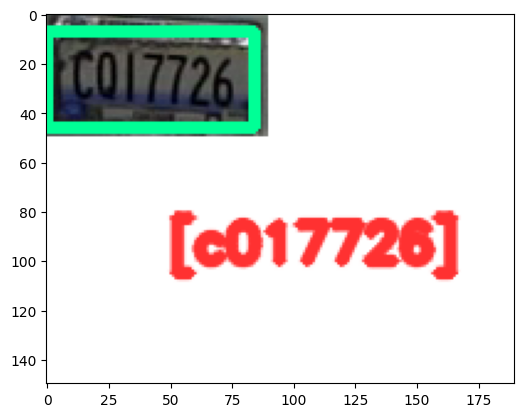

  ocrextractor.labels                                ocrextractor.bboxes  \
0         [[c017726]]             [[[0, 7], [84, 7], [84, 46], [0, 46]]]   
1      [TN-48.0.5566]  [[[432, 648], [723, 648], [723, 698], [432, 69...   
2    [CID, INaQ 3044]  [[[310, 196], [374, 196], [374, 220], [310, 22...   

                        ocrextractor.scores  
0                     [0.23887794246165342]  
1                       [0.765264012834225]  
2  [0.2939907229681601, 0.5979598335637649]  


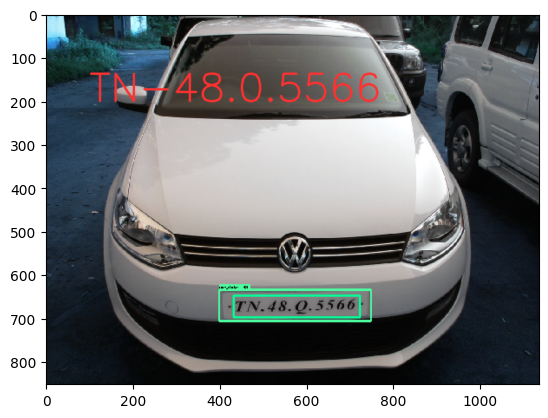

  ocrextractor.labels                                ocrextractor.bboxes  \
0         [[c017726]]             [[[0, 7], [84, 7], [84, 46], [0, 46]]]   
1      [TN-48.0.5566]  [[[432, 648], [723, 648], [723, 698], [432, 69...   
2    [CID, INaQ 3044]  [[[310, 196], [374, 196], [374, 220], [310, 22...   

                        ocrextractor.scores  
0                     [0.23887794246165342]  
1                       [0.765264012834225]  
2  [0.2939907229681601, 0.5979598335637649]  


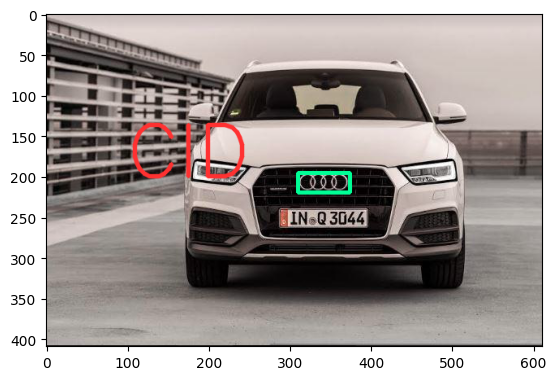

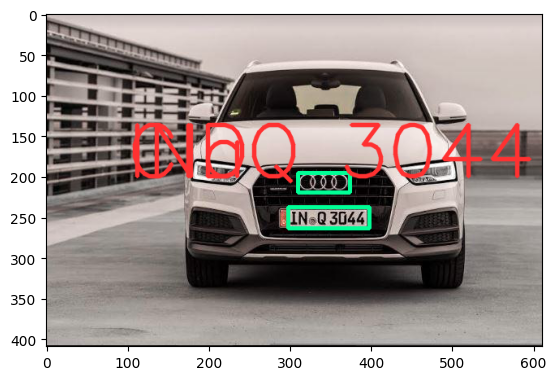

In [80]:
dataframe = response.batch.frames
annotate_image_ocr(dataframe, 'frame0_plate0.png', frame_id = 0)
annotate_image_ocr(dataframe, 'test_image_1.png', frame_id = 1)
annotate_image_ocr(dataframe, 'test_image_2.png', frame_id = 2)